# Azure Computer Vision 4 (Florence)

## Fashion Visual Search - Images clustering

![Image](florence.jpg)

![Image](fashionheader.png)

<br>
<i>Note: this image was generated with Azure Open AI Dall-e 2</i>

### Visual search with vector embeddings
**Vector embeddings** are a way of representing content such as text or images as vectors of real numbers in a high-dimensional space. These embeddings are often learned from large amounts of textual and visual data using machine learning algorithms like neural networks. Each dimension of the vector corresponds to a different feature or attribute of the content, such as its semantic meaning, syntactic role, or context in which it commonly appears. By representing content as vectors, we can perform mathematical operations on them to compare their similarity or use them as inputs to machine learning models.

![Image](embeddings.jpg)


### Business applications
- **Digital asset management**: Image retrieval can be used to manage large collections of digital images, such as in museums, archives, or online galleries. Users can search for images based on visual features and retrieve the images that match their criteria.
- **Medical image retrieval**: Image retrieval can be used in medical imaging to search for images based on their diagnostic features or disease patterns. This can help doctors or researchers to identify similar cases or track disease progression.
- **Security and surveillance**: Image retrieval can be used in security and surveillance systems to search for images based on specific features or patterns, such as in, people & object tracking, or threat detection.
- **Forensic image retrieval**: Image retrieval can be used in forensic investigations to search for images based on their visual content or metadata, such as in cases of cyber-crime.
- **E-commerce**: Image retrieval can be used in online shopping applications to search for similar products based on their features or descriptions or provide recommendations based on previous purchases.
- **Fashion and design**: Image retrieval can be used in fashion and design to search for images based on their visual features, such as color, pattern, or texture. This can help designers or retailers to identify similar products or trends.

### Visual Search Process
![Image](fashionprocess.png)

### Image Retrieval with Azure Computer Vision Documentation
- https://learn.microsoft.com/en-us/azure/cognitive-services/computer-vision/concept-image-retrieval
- https://learn.microsoft.com/en-us/azure/cognitive-services/computer-vision/how-to/image-retrieval

### Demo images
Demo images are a sample of this collection of images: https://www.kaggle.com/competitions/h-and-m-personalized-fashion-recommendations/data
<br><br>
> Serge Retkowsky | Microsoft | https://github.com/retkowsky | 3rd of May, 2023

## 1. <a name="chapt1"></a> Librairies

In [1]:
import datetime
import glob
import json
import matplotlib.pyplot as plt
import numpy as np
import nomic
import os
import pandas as pd
import plotly.express as px
import sys
import time
import warnings

warnings.filterwarnings("ignore")

from dotenv import load_dotenv
from nomic import atlas
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from PIL import Image
from umap import UMAP

In [2]:
# Getting Azure CV endpoint and key from the azure.env file

load_dotenv("azure.env")
key = os.getenv("azure_cv_key")
endpoint = os.getenv("azure_cv_endpoint")

### Importing our specific functions

In [3]:
pyfile = "azure.py"

print("Python file:", pyfile, "Date:", time.ctime(os.path.getmtime(pyfile)))

Python file: azure.py Date: Fri Jul  7 09:37:12 2023


In [4]:
from azure import view_image

## 2. <a name="chapt2"></a> Informations

In [5]:
sys.version

'3.10.5 (tags/v3.10.5:f377153, Jun  6 2022, 16:14:13) [MSC v.1929 64 bit (AMD64)]'

In [6]:
print("Today is", datetime.datetime.today())

Today is 2023-07-10 10:54:37.367453


## 3. <a name="chapt3"></a> Our products images

In [7]:
IMAGES_DIR = "fashion"

In [8]:
image_files = glob.glob(IMAGES_DIR + "/*")

print("Directory of images:", IMAGES_DIR)
print("Total number of catalog images =", "{:,}".format(len(image_files)))

Directory of images: fashion
Total number of catalog images = 252


### Some images

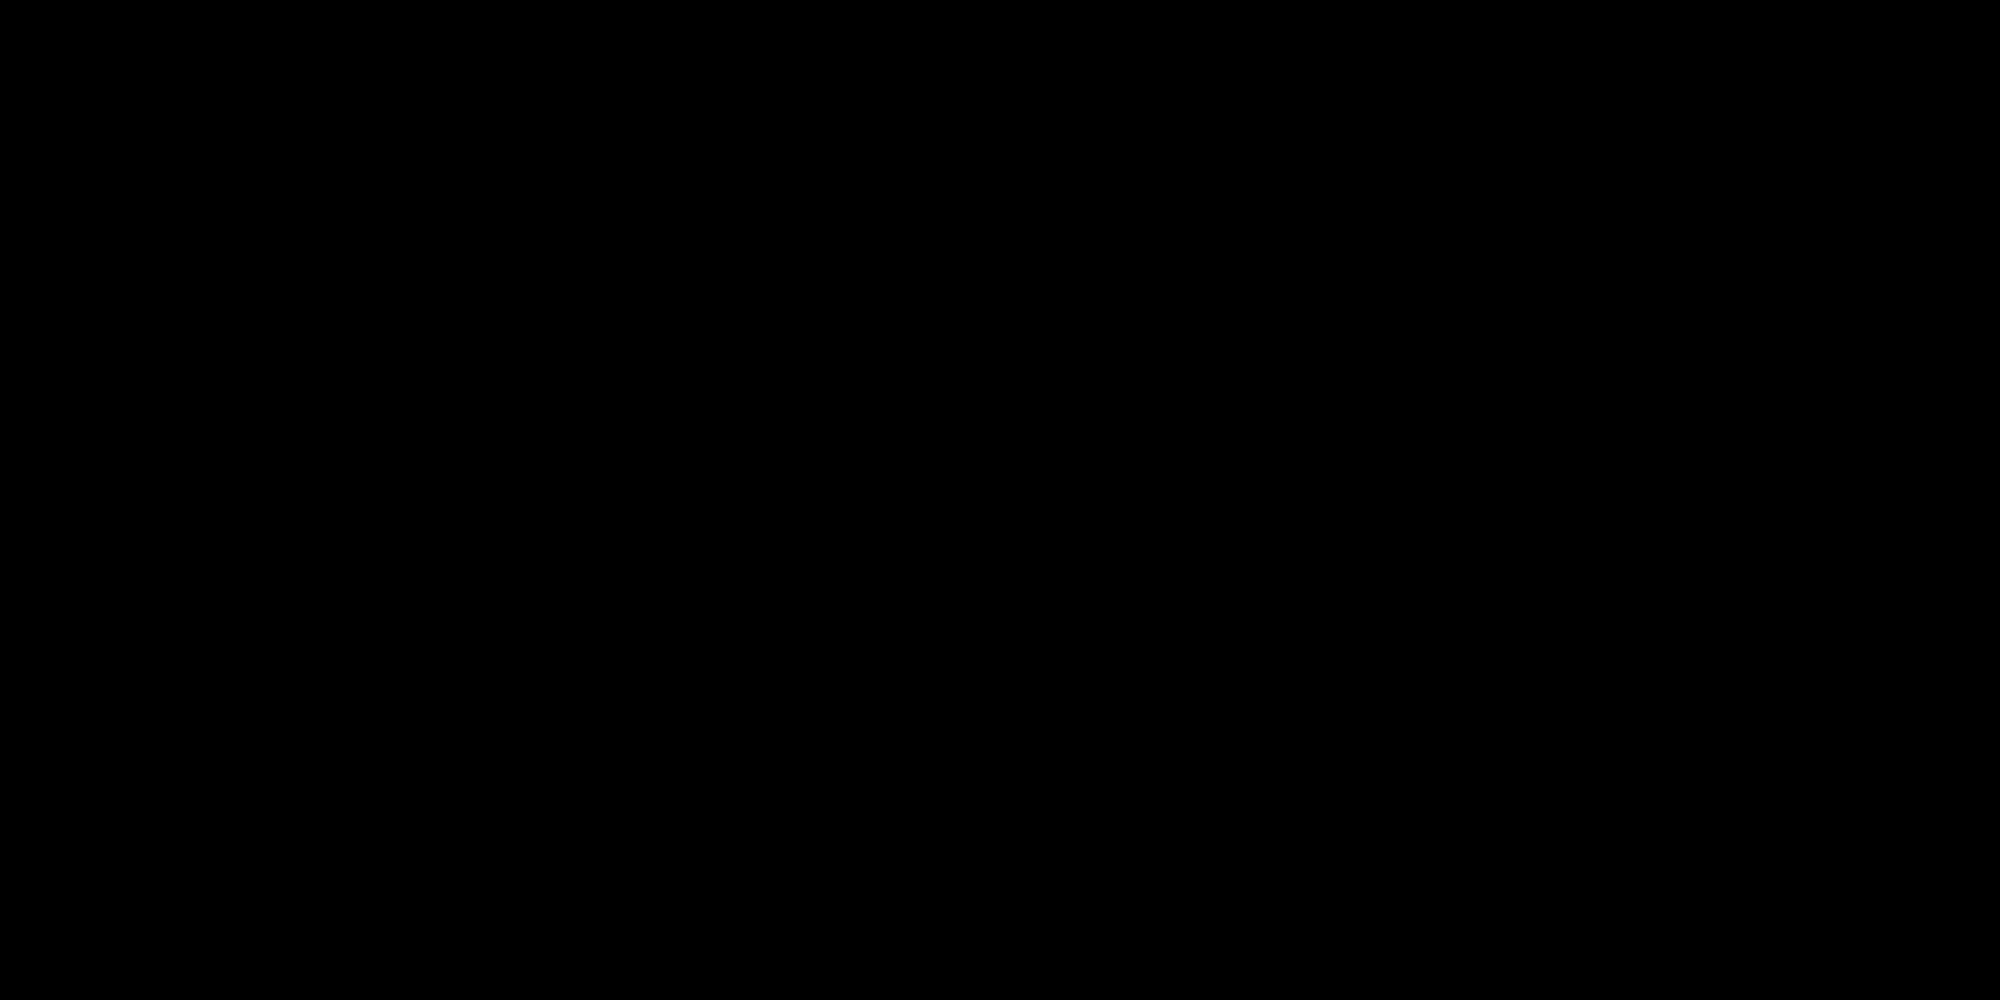

In [9]:
num_images_per_row = 10
num_images_per_col = 5

img_size = 200
start = 500
samples = image_files[start : start + (num_images_per_row * num_images_per_col)]

samples_images = Image.new(
    "RGB", (num_images_per_row * img_size, num_images_per_col * img_size)
)

for idx, image_file in enumerate(samples):
    img = Image.open(image_file)
    img = img.resize((img_size, img_size))
    x = (idx % num_images_per_row) * img_size
    y = (idx // num_images_per_row) * img_size
    samples_images.paste(img, (x, y))

samples_images

## 4. <a name="chapt4"></a> Loading vector embeddings

In [10]:
JSON_DIR = "json"

glob.glob(JSON_DIR + "/*.json")

['json\\img_embed_10Jul2023_085637.json']

In [11]:
print("Importing vectors embeddings...")

jsonfiles = [entry.name for entry in os.scandir(JSON_DIR) if entry.is_file()]
jsonfiles = [f for f in jsonfiles if os.path.isfile(os.path.join(JSON_DIR, f))]

# Get the most recent file
modification_times = [
    (f, os.path.getmtime(os.path.join(JSON_DIR, f))) for f in jsonfiles
]
modification_times.sort(key=lambda x: x[1], reverse=True)
most_recent_file = JSON_DIR + "/" + modification_times[0][0]

# Loading the most recent file
print(f"Loading the most recent file of the vector embeddings: {most_recent_file}")

with open(most_recent_file) as f:
    list_emb = json.load(f)

print(f"\nDone: number of imported vector embeddings = {len(list_emb):,}")

Importing vectors embeddings...
Loading the most recent file of the vector embeddings: json/img_embed_10Jul2023_085637.json

Done: number of imported vector embeddings = 252


## 5. <a name="chapt5"></a> Clustering

In [12]:
print("Total number of embedded catalog images =", "{:,}".format(len(list_emb)))

Total number of embedded catalog images = 252


In [13]:
# Running the kmeans on the images vector embeddings
# and displaying the values of silhouette score
#what is kmeans clustering - https://www.youtube.com/watch?v=4b5d3muPQmA 
k_values = range(2, 20)
silhouette_scores = []
max_val = []

print("Performing some K-Means...\n")

for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=123456)
    kmeans.fit(list_emb)
    labels = kmeans.labels_
    score = silhouette_score(list_emb, labels)
    max_val.append(score)
    max_val.sort(reverse=True)
    silhouette_scores.append(score)

    print(
        f"For k = {k:02} => Silhouette score = {score:.5f} | Maximum score = {max_val[0]:.5f}"
    )

Performing some K-Means...



  File "c:\Users\Dell\OneDrive - Northeastern University\courses\big data and intl analytics\DAMG7245-Summer2023\assignment_3\env_cv\lib\site-packages\joblib\externals\loky\backend\context.py", line 257, in _count_physical_cores
    cpu_info = subprocess.run(
  File "C:\Users\Dell\AppData\Local\Programs\Python\Python310\lib\subprocess.py", line 501, in run
    with Popen(*popenargs, **kwargs) as process:
  File "C:\Users\Dell\AppData\Local\Programs\Python\Python310\lib\subprocess.py", line 969, in __init__
    self._execute_child(args, executable, preexec_fn, close_fds,
  File "C:\Users\Dell\AppData\Local\Programs\Python\Python310\lib\subprocess.py", line 1438, in _execute_child
    hp, ht, pid, tid = _winapi.CreateProcess(executable, args,


For k = 02 => Silhouette score = 0.05445 | Maximum score = 0.05445
For k = 03 => Silhouette score = 0.05051 | Maximum score = 0.05445
For k = 04 => Silhouette score = 0.04723 | Maximum score = 0.05445
For k = 05 => Silhouette score = 0.05513 | Maximum score = 0.05513
For k = 06 => Silhouette score = 0.04907 | Maximum score = 0.05513
For k = 07 => Silhouette score = 0.05701 | Maximum score = 0.05701
For k = 08 => Silhouette score = 0.05020 | Maximum score = 0.05701
For k = 09 => Silhouette score = 0.06072 | Maximum score = 0.06072
For k = 10 => Silhouette score = 0.05895 | Maximum score = 0.06072
For k = 11 => Silhouette score = 0.06294 | Maximum score = 0.06294
For k = 12 => Silhouette score = 0.07049 | Maximum score = 0.07049
For k = 13 => Silhouette score = 0.06322 | Maximum score = 0.07049
For k = 14 => Silhouette score = 0.06669 | Maximum score = 0.07049
For k = 15 => Silhouette score = 0.06246 | Maximum score = 0.07049
For k = 16 => Silhouette score = 0.05516 | Maximum score = 0.0

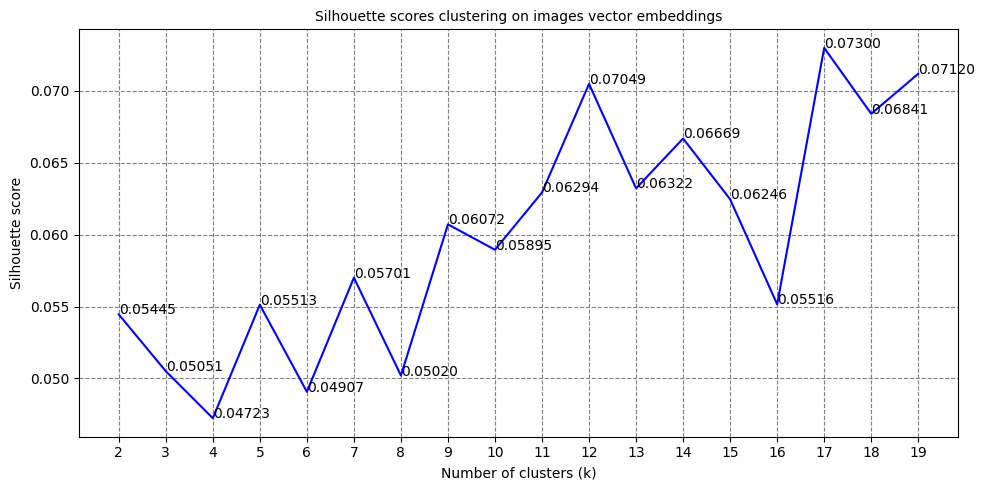

In [14]:
OUTPUT_DIR = "output"

os.makedirs(OUTPUT_DIR, exist_ok=True)

plt.figure(figsize=(10, 5))
plt.plot(k_values, silhouette_scores, color="blue")
plt.title("Silhouette scores clustering on images vector embeddings", size=10)
plt.grid(True, color="grey", linestyle="--")

for k, silh in zip(k_values, silhouette_scores):
    plt.text(k, silh, f"{silh:.5f}")

plt.xticks(k_values)
plt.xlabel("Number of clusters (k)")
plt.ylabel("Silhouette score")
plt.tight_layout()

plt.savefig(os.path.join(OUTPUT_DIR, "silhouette_plot.png"))
plt.show()

In [15]:
nb_clusters = 17

kmeans = KMeans(n_clusters=nb_clusters, 
                random_state=123456)

kmeans.fit(list_emb)
labels = kmeans.labels_

print("Cluster labels:\n", labels)
print("\nCluster centers:\n", kmeans.cluster_centers_)
print("\nWithin-cluster sum of squares (inertia) =", kmeans.inertia_)

Cluster labels:
 [ 6  4 15  2  2  1 16  5  2  2  2  9  9 10  3  3  3 10  4 12 15  7  1  7
 15 15  5 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15  0 14  6  3  7  4
 13  5  1 12  7  1  3  3  9  0  9  9  9  9  9  4  9  9  9  9  4  4  4  4
 14  4  7  5 10  7  3  3  3  3  3  3  4  4 10  1  6  6  3  7 12  4  7 12
  3  8  8  7  7  2 11 11  7  7 14  4  1  0  7  2  4 15  7  7  1  1  2  2
  2  2  2  2  2  2  1  2  2  2  0 13 11 11 11 11 13 13  3  3  3 13 10 16
 16 12  6 11  0  7  0  7  7  7  1  6  6 14  8  8  7  7  7 14  0  6  1  1
  3  3 16  2  1  4  6  6  7 15  1 14  8  8  8  8  8  8 12  8 12  6 15 15
  2  2  4  0 12  7 11  1  6  9  6  2  1  5 12  6  4  1 10  3 15 14 10  3
  3  7 14 10  2 16 16 16 14 11 10 10 10 12  7  9  9 10  4  4  3  3  3  7
  2  6  3  3  2 16  5 15 15 16 16 10]

Cluster centers:
 [[-2.88287352  3.3092041   0.18113708 ... -0.54758454 -2.04676819
  -4.67456055]
 [-0.81325755  1.50046405 -0.36203182 ... -1.48282579 -0.70520737
  -3.79124539]
 [-1.30805664  1.96335938 -0.03317

Text(0, 0.5, 'Frequency')

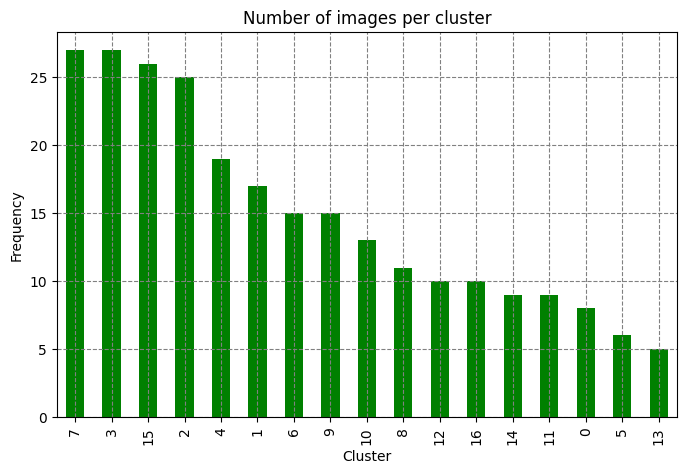

In [16]:
cluster_series = pd.Series(labels, name="cluster")

ax = cluster_series.value_counts().plot(
    kind="bar", figsize=(8, 5), title="Number of images per cluster", color="green"
)

plt.grid(True, color="grey", linestyle="--")
ax.set_xlabel("Cluster")
ax.set_ylabel("Frequency")

In [17]:
df_clusters = pd.DataFrame(
    {"image_file": image_files, "vector": list_emb, "cluster": labels}
)

In [18]:
df_clusters

image_file  \
0    fashion\0391032009.jpg   
1    fashion\0391750016.jpg   
2    fashion\0392168001.jpg   
3    fashion\0392269012.jpg   
4    fashion\0392938035.jpg   
..                      ...   
247  fashion\0624251001.jpg   
248  fashion\0624257005.jpg   
249  fashion\0624311004.jpg   
250  fashion\0624351001.jpg   
251  fashion\0624383005.jpg   

                                                vector  cluster  
0    [-3.7421875, 2.6816406, -1.5712891, -3.1035156...        6  
1    [-2.7363281, 3.2421875, 0.034210205, 0.1082153...        4  
2    [-1.0273438, 2.8144531, -1.4179688, -3.1679688...       15  
3    [-1.8115234, 1.6435547, -3.5253906, -2.6953125...        2  
4    [0.27734375, 1.2304688, 1.5859375, -1.9287109,...        2  
..                                                 ...      ...  
247  [-0.39501953, 3.4414062, 0.56396484, -2.126953...       15  
248  [-2.8144531, 3.2890625, 1.2753906, 0.20947266,...       15  
249  [-2.6914062, 1.6162109, -0.44921875, -0.347412...       16  
250  [-6.0, 1.5732422, 1.0996094, 2.3691406, 2.7246...       16  
251  [-2.2753906, 3.2695312, 3.1933594, -1.8359375,...       10  

[252 rows x 3 columns]

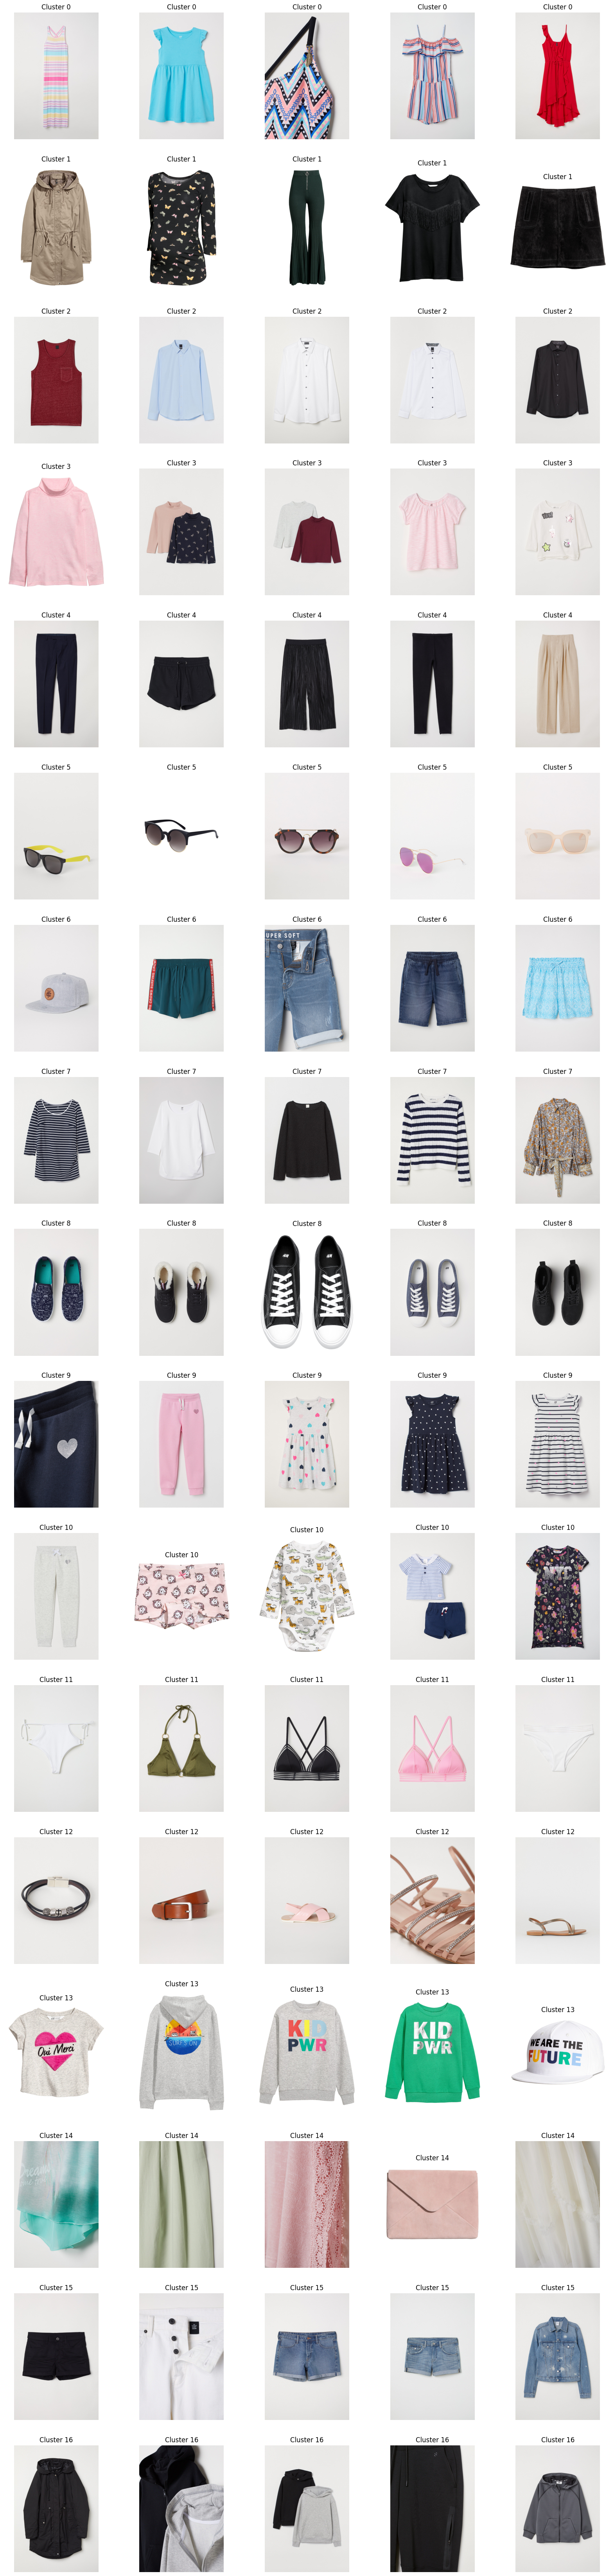

In [21]:
# Define number of images to display per cluster
num_images_per_cluster = 5

# Get list of clusters in DataFrame
clusters = df_clusters["cluster"].unique()
# Sorted list
clusters = np.sort(clusters)

# Only include the first 3 clusters
clusters = clusters[:3]

# Create figure with subplots
num_rows = len(clusters)
fig, axes = plt.subplots(num_rows, num_images_per_cluster, figsize=(20, 5*num_rows))

# Display images on subplots
for i, cluster in enumerate(clusters):
    # Get rows in DataFrame for current cluster
    cluster_rows = df_clusters[df_clusters["cluster"] == cluster].head(num_images_per_cluster)
    for j, row in enumerate(cluster_rows.itertuples(index=False)):
        img = Image.open(row.image_file)
        axes[i, j].imshow(img)
        axes[i, j].set_title(f"Cluster {row.cluster}")
        axes[i, j].axis("off")

plt.show()

## Let's define the clusters labels

In [22]:
cluster_labels = [
    "0", "Women's dresses",
    "1", "Denim",
    "2", "Shirt",
    "3", "Full sleeves",
    "4", "Pant",
    "5", "Sun glasses",
    "6", "Shorts",
    "7", "Winter wear",
    "8", "Shoes",
    "9", "Skirt",
    "10", "Kids wear",
    "11", "Lingerie",
    "12", "Accessories",
    "13", "Hoodie",
    "14", "Cloth",
    "15", "Denim shorts",
    "16", "Jacket",
]

In [23]:
cluster_ids = [int(cluster_labels[i]) for i in range(0, len(cluster_labels), 2)]
category_names = [cluster_labels[i + 1] for i in range(0, len(cluster_labels), 2)]

cluster_ids_series = pd.Series(cluster_ids, name="cluster")
cluster_names_series = pd.Series(category_names, name="cluster_label")
cluster_labels_df = pd.concat([cluster_ids_series, cluster_names_series], axis=1)
df_results = pd.merge(df_clusters, cluster_labels_df, on="cluster", how="left")
# Adding 1 to avoid the number 0
df_results["cluster"] = df_results["cluster"].apply(lambda x: int(x) + 1)
# Numbers in 2 characters
df_results["cluster"] = df_results["cluster"].apply(
    lambda x: f"0{x}" if int(x) < 10 else x
)
# Adding some text
df_results["cluster"] = df_results["cluster"].astype(str)
df_results["Cluster and Label"] = (
    "Cluster " + df_results["cluster"] + " = " + df_results["cluster_label"]
)
df_results

image_file  \
0    fashion\0391032009.jpg   
1    fashion\0391750016.jpg   
2    fashion\0392168001.jpg   
3    fashion\0392269012.jpg   
4    fashion\0392938035.jpg   
..                      ...   
247  fashion\0624251001.jpg   
248  fashion\0624257005.jpg   
249  fashion\0624311004.jpg   
250  fashion\0624351001.jpg   
251  fashion\0624383005.jpg   

                                                vector cluster cluster_label  \
0    [-3.7421875, 2.6816406, -1.5712891, -3.1035156...      07        Shorts   
1    [-2.7363281, 3.2421875, 0.034210205, 0.1082153...      05          Pant   
2    [-1.0273438, 2.8144531, -1.4179688, -3.1679688...      16  Denim shorts   
3    [-1.8115234, 1.6435547, -3.5253906, -2.6953125...      03         Shirt   
4    [0.27734375, 1.2304688, 1.5859375, -1.9287109,...      03         Shirt   
..                                                 ...     ...           ...   
247  [-0.39501953, 3.4414062, 0.56396484, -2.126953...      16  Denim shorts   
248  [-2.8144531, 3.2890625, 1.2753906, 0.20947266,...      16  Denim shorts   
249  [-2.6914062, 1.6162109, -0.44921875, -0.347412...      17        Jacket   
250  [-6.0, 1.5732422, 1.0996094, 2.3691406, 2.7246...      17        Jacket   
251  [-2.2753906, 3.2695312, 3.1933594, -1.8359375,...      11     Kids wear   

             Cluster and Label  
0          Cluster 07 = Shorts  
1            Cluster 05 = Pant  
2    Cluster 16 = Denim shorts  
3           Cluster 03 = Shirt  
4           Cluster 03 = Shirt  
..                         ...  
247  Cluster 16 = Denim shorts  
248  Cluster 16 = Denim shorts  
249        Cluster 17 = Jacket  
250        Cluster 17 = Jacket  
251     Cluster 11 = Kids wear  

[252 rows x 5 columns]

In [24]:
# Saving the results in a json file
df_results.to_json(os.path.join(OUTPUT_DIR, "clusters.json"))

Text(0, 0.5, 'Frequency')

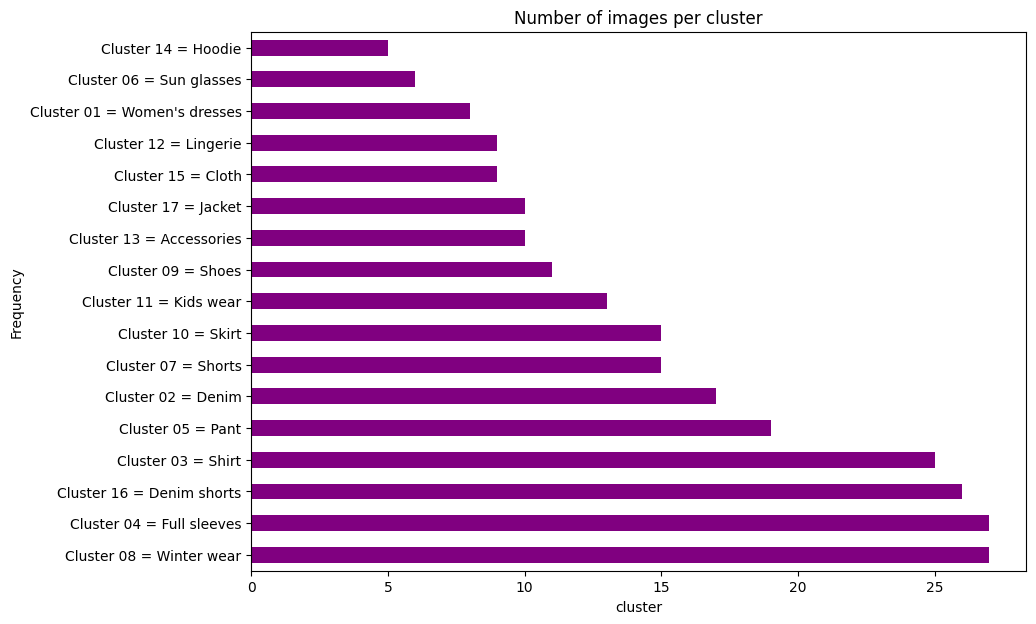

In [25]:
ax = (
    df_results["Cluster and Label"]
    .value_counts()
    .plot(
        kind="barh",
        figsize=(10, 7),
        title="Number of images per cluster",
        color="purple",
    )
)

ax.set_xlabel("cluster")
ax.set_ylabel("Frequency")

## 6 Clustering analysis

### Using Atlas Nomic

https://atlas.nomic.ai/

During indexing, **Atlas builds a contextual two-dimensional data map of embeddings**. 
This map preserves high-dimensional relationships present between embeddings in a two-dimensional,
human interpretable view.

You can get a free key at https://atlas.nomic.ai/cli-login

In [26]:
load_dotenv("azure.env")

atlas_nomic_key = os.getenv("atlas_nomic_key")
nomic.login(atlas_nomic_key)

In [27]:
clusterlabel = df_results["cluster_label"].tolist()

datapoints = [
    {"filename": image_file_name, "id": i, "clusterlabel": clusterlabel[i]}
    for i, image_file_name in enumerate(image_files)
]

project = atlas.map_embeddings(
    embeddings=np.array(list_emb),  # images vector embeddings
    data=datapoints,  # datapoints
    id_field="id",  # id
    name="image_file_name",  # image filename
    colorable_fields=["clusterlabel"],  # cluster label
    reset_project_if_exists=True,
    is_public=True,  # public map
)

map = project.get_map(
    "Clustering images vector embeddings with Azure Computer Vision 4"
)
print(map)

project.maps[0]

2023-07-10 11:23:07.012 | INFO     | nomic.project:__init__:665 - Found existing project `image_file_name` in organization `sukruth0402`. Clearing it of data by request.
2023-07-10 11:23:08.504 | INFO     | nomic.project:_create_project:753 - Creating project `image_file_name` in organization `sukruth0402`
2023-07-10 11:23:12.848 | INFO     | nomic.atlas:map_embeddings:107 - Uploading embeddings to Atlas.
2023-07-10 11:23:13.000 | WARNING  | nomic.project:_validate_and_correct_arrow_upload:254 - id_field is not a string. Converting to string from int32
1it [00:02,  2.76s/it]
2023-07-10 11:23:16.014 | INFO     | nomic.project:_add_data:1375 - Upload succeeded.
2023-07-10 11:23:16.024 | INFO     | nomic.atlas:map_embeddings:126 - Embedding upload succeeded.
2023-07-10 11:23:17.127 | INFO     | nomic.project:create_index:1085 - Created map `image_file_name` in project `image_file_name`: https://atlas.nomic.ai/map/63855d59-7bda-4a99-9924-b67c197ec057/1b05aa2c-aeaa-433e-92e1-1e195e8f070a
20

image_file_name: https://atlas.nomic.ai/map/63855d59-7bda-4a99-9924-b67c197ec057/1b05aa2c-aeaa-433e-92e1-1e195e8f070a


image_file_name: https://atlas.nomic.ai/map/63855d59-7bda-4a99-9924-b67c197ec057/1b05aa2c-aeaa-433e-92e1-1e195e8f070a

### We have a map like that one. Each point is an image. Each color is a cluster.

![Image](map2.png)

### These two images were close on the map. They are quite similar (same kind of shoes)

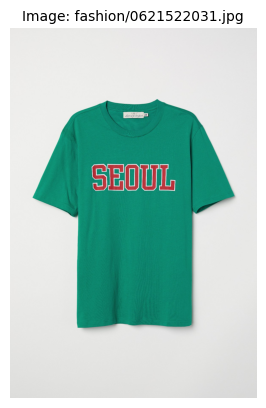

In [28]:
view_image("fashion/0621522031.jpg")

In [30]:
#view_image("fashion/0649440002.jpg")

### Using UMAP on the clustered data

**Dimensionality reduction** is a valuable tool utilized by machine learning practitioners to gain insights and interpret large, complex datasets that have a high number of dimensions.

Among the visualization techniques available, t-SNE is popular, but it may be challenging to use and may perform poorly with larger datasets. Recently, McInnes et al. developed a new method called **UMAP**, which offers several advantages over t-SNE, such as faster computation and better preservation of the data's global structure.

In [31]:
print("Running Umap on the images vectors embeddings...")

start = time.time()
umap_2d = UMAP(n_components=2, init="random", random_state=0)
proj_2d = umap_2d.fit_transform(list_emb)

print("Done")
elapsed = time.time() - start
print(
    "Elapsed time: "
    + time.strftime(
        "%H:%M:%S.{}".format(str(elapsed % 1)[2:])[:15], time.gmtime(elapsed)
    )
)

Running Umap on the images vectors embeddings...


Done
Elapsed time: 00:01:28.229000


In [32]:
fig_2d = px.scatter(
    proj_2d,
    x=0,
    y=1,
    color=df_results["cluster_label"].tolist(),
    labels={"color": "Cluster"},
    custom_data=[df_results["image_file"].tolist(), df_results["Cluster and Label"].tolist()],
    title="Images Vectors Embeddings UMAP Projections",
    height=640,
)

fig_2d.update_traces(marker_size=5, hovertemplate = "%{customdata}")
fig_2d.show()

In [33]:
print("Running Umap on the images vectors embeddings...")

start = time.time()
umap_3d = UMAP(n_components=3, init="random", random_state=0)
proj_3d = umap_3d.fit_transform(list_emb)

print("Done")
elapsed = time.time() - start
print(
    "Elapsed time: "
    + time.strftime(
        "%H:%M:%S.{}".format(str(elapsed % 1)[2:])[:15], time.gmtime(elapsed)
    )
)

Running Umap on the images vectors embeddings...


Done
Elapsed time: 00:00:19.476014


In [34]:
fig_3d = px.scatter_3d(
    proj_3d,
    x=0,
    y=1,
    z=2,
    color=clusterlabel,
    labels={"color": "Cluster"},
    custom_data=[df_results["image_file"].tolist(), df_results["Cluster and Label"].tolist()],
    title="Images Vectors Embeddings UMAP Projections",
    height=860,
)

fig_3d.update_traces(marker_size=3, hovertemplate = "%{customdata}")
fig_3d.show()

> End